In [62]:
import numpy as np
from openqaoa.problems import BinPacking, MaximumCut
import json
import pprint
import networkx as nx

In [63]:
desiredProblemType = 'MaxCut' #options: 'BinPacking', 'MaxCut'

In [68]:
if desiredProblemType == 'BinPacking':
    n_items = 2 # number of items
    n_bins = 2 # maximum number of bins the solution will be explored on
    min_weight = 1 # minimum weight of the items
    max_weight = 3 # maximum weight of the items
    weight_capacity = 5 # weight capacity of the bins
    weights = np.random.default_rng(seed=1234).integers(low=min_weight, high=max_weight, size=n_items) # random instance of the problem

    bpp = BinPacking(weights, weight_capacity, n_bins=n_bins, simplifications=False) #it is here that you would specifiy the penalty for the bin packing problem
    quboProb = bpp.qubo

elif desiredProblemType == 'MaxCut':
    G = nx.generators.fast_gnp_random_graph(n=6, p=0.6, seed=42)
    maxcut_prob = MaximumCut(G)
    quboProb = maxcut_prob.qubo

quboProb.hamiltonian.expression

0 + 1.0Z_{0}Z_{2} + 1.0Z_{0}Z_{3} + 1.0Z_{0}Z_{4} + 1.0Z_{1}Z_{2} + 1.0Z_{1}Z_{3} + 1.0Z_{1}Z_{5} + 1.0Z_{2}Z_{4} + 1.0Z_{2}Z_{5} + 1.0Z_{3}Z_{5} + 1.0Z_{4}Z_{5}

In [69]:
qubo_dict = quboProb.asdict()
data_to_save = {
    "terms": qubo_dict["terms"],
    "weights": qubo_dict["weights"],
    "constant": qubo_dict.get("constant", 0.0),
    "problem_type": qubo_dict.get("problem_instance", {}).get("problem_type", "unknown")
}

file_path = "qubo_data.json"
with open(file_path, "w") as f:
    json.dump(data_to_save, f)

print(f"QUBO data saved to {file_path}")
print("Saved data structure example:")
#print(json.dumps(data_to_save, indent=2))
print(quboProb.asdict()) # Original full dictionary from OpenQAOA

QUBO data saved to qubo_data.json
Saved data structure example:
{'terms': [[0, 2], [0, 3], [0, 4], [1, 2], [1, 3], [1, 5], [2, 4], [2, 5], [3, 5], [4, 5]], 'weights': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'constant': 0, 'n': 6, 'problem_instance': {'problem_type': 'maximum_cut', 'G': {'directed': False, 'multigraph': False, 'graph': {}, 'nodes': [{'id': 0}, {'id': 1}, {'id': 2}, {'id': 3}, {'id': 4}, {'id': 5}], 'links': [{'source': 0, 'target': 2}, {'source': 0, 'target': 3}, {'source': 0, 'target': 4}, {'source': 1, 'target': 2}, {'source': 1, 'target': 3}, {'source': 1, 'target': 5}, {'source': 2, 'target': 4}, {'source': 2, 'target': 5}, {'source': 3, 'target': 5}, {'source': 4, 'target': 5}]}}, 'metadata': {}}


In [70]:
#exact solver for later comparison to qunatum results
hamiltonian = quboProb.hamiltonian
# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -6.0, Solution: ['001110', '110001']


(<Figure size 1000x600 with 1 Axes>, <Axes: >)

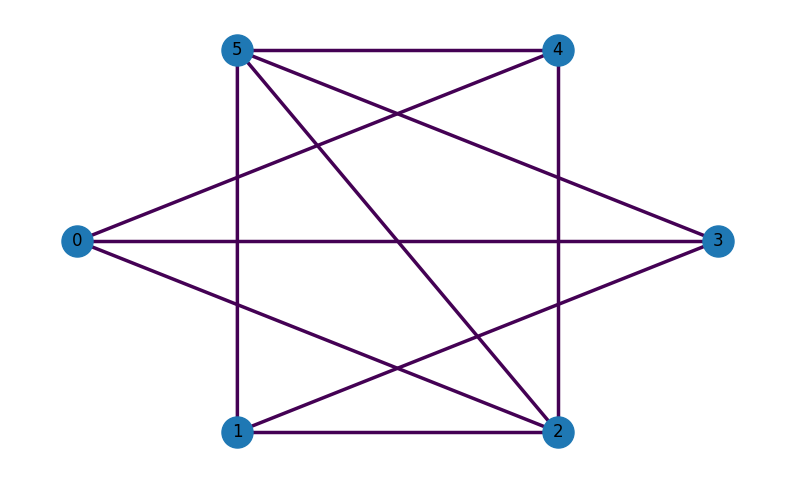

In [71]:
#bpp.classical_solution #something here about finding the solution classically can explore 
from openqaoa.utilities import plot_graph
plot_graph(G)